In [5]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pprint import pprint
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
from tqdm.notebook import tqdm
import nibabel as nib
import glmsingle
from glmsingle.glmsingle import GLM_single

dir2 = os.path.abspath('../..')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: 
    sys.path.append(dir1)

from research.experiments.tc2see.analysis import (
    get_design_matrix,
)
from research.experiments.tc2see.data_loading import (
    Data,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
subject = "01"  # subjects 01 and 02
task = "bird"
space = "T1w"
#space = "MNI152NLin2009cAsym"
tr = 1.97
version = 1
dataset_path = Path(f"D:\\Datasets\\TC2See_v{version}")
num_runs = 6 if version == 1 else 8
#num_runs = 2
run_ids = [1,2,3,4,5,6]
#data = Data(str(dataset_path), subject, task, 1, space)
#data.events

In [7]:
from scipy.ndimage import zoom

# Load runs
resample_tr = tr
fmri_mask = None
fmri_batch = []
events_batch = []
for run in tqdm(run_ids):
    data = Data(str(dataset_path), subject, task, run, space)
    events_batch.append(data.events)

    fmri_data = data.fmri_img.get_fdata()
    if fmri_mask is None:
        fmri_mask = data.mask.get_fdata().astype(bool)
    fmri_data_masked = fmri_data[fmri_mask]
    #fmri_data_masked = zoom(fmri_data_masked, zoom=(1, tr / resample_tr))
    fmri_batch.append(fmri_data_masked)

  0%|          | 0/6 [00:00<?, ?it/s]

G:\python_env\glm-single\lib\site-packages\bids\config.py:39: FutureWarning: Setting 'extension_initial_dot' will be removed in pybids 0.16.
  warnings.warn("Setting 'extension_initial_dot' will be removed in pybids 0.16.",


fmri_img D:\Datasets\TC2See_v1\derivatives_TC2See_prdgm\fmriprep\sub-01\func\sub-01_task-bird_run-1_space-T1w_desc-preproc_bold.nii.gz
mask D:\Datasets\TC2See_v1\derivatives_TC2See_prdgm\fmriprep\sub-01\func\sub-01_task-bird_run-1_space-T1w_desc-brain_mask.nii.gz


G:\python_env\glm-single\lib\site-packages\bids\config.py:39: FutureWarning: Setting 'extension_initial_dot' will be removed in pybids 0.16.
  warnings.warn("Setting 'extension_initial_dot' will be removed in pybids 0.16.",


fmri_img D:\Datasets\TC2See_v1\derivatives_TC2See_prdgm\fmriprep\sub-01\func\sub-01_task-bird_run-2_space-T1w_desc-preproc_bold.nii.gz


G:\python_env\glm-single\lib\site-packages\bids\config.py:39: FutureWarning: Setting 'extension_initial_dot' will be removed in pybids 0.16.
  warnings.warn("Setting 'extension_initial_dot' will be removed in pybids 0.16.",


fmri_img D:\Datasets\TC2See_v1\derivatives_TC2See_prdgm\fmriprep\sub-01\func\sub-01_task-bird_run-3_space-T1w_desc-preproc_bold.nii.gz


G:\python_env\glm-single\lib\site-packages\bids\config.py:39: FutureWarning: Setting 'extension_initial_dot' will be removed in pybids 0.16.
  warnings.warn("Setting 'extension_initial_dot' will be removed in pybids 0.16.",


fmri_img D:\Datasets\TC2See_v1\derivatives_TC2See_prdgm\fmriprep\sub-01\func\sub-01_task-bird_run-4_space-T1w_desc-preproc_bold.nii.gz


G:\python_env\glm-single\lib\site-packages\bids\config.py:39: FutureWarning: Setting 'extension_initial_dot' will be removed in pybids 0.16.
  warnings.warn("Setting 'extension_initial_dot' will be removed in pybids 0.16.",


fmri_img D:\Datasets\TC2See_v1\derivatives_TC2See_prdgm\fmriprep\sub-01\func\sub-01_task-bird_run-5_space-T1w_desc-preproc_bold.nii.gz


G:\python_env\glm-single\lib\site-packages\bids\config.py:39: FutureWarning: Setting 'extension_initial_dot' will be removed in pybids 0.16.
  warnings.warn("Setting 'extension_initial_dot' will be removed in pybids 0.16.",


fmri_img D:\Datasets\TC2See_v1\derivatives_TC2See_prdgm\fmriprep\sub-01\func\sub-01_task-bird_run-6_space-T1w_desc-preproc_bold.nii.gz


In [10]:
# Collect all conditions
conditions = []
for run_id, events in enumerate(events_batch):
    for id, event in events.iterrows():
        if not event['stimulus'].endswith('png'):
            continue
        condition_name = Path(event['stimulus']).stem.split('.')[1]
        conditions.append(condition_name)
conditions = list(set(conditions))
conditions.sort()
conditions = {condition: i for i, condition in enumerate(conditions)}
C = len(conditions)

_, T = fmri_batch[0].shape

design_batch = []
for run_id, events in enumerate(events_batch):
    _, T = fmri_batch[run_id].shape
    design_matrix = np.zeros(shape=(T, C))
    for id, event in events.iterrows():
        if not event['stimulus'].endswith('png'):
            continue
        condition_name = Path(event['stimulus']).stem.split('.')[1]
        c = conditions[condition_name]
        t = round(event.tr)
        design_matrix[t, c] = 1
    design_batch.append(design_matrix)

@interact(run_id=(0, len(design_batch)-1))
def show(run_id):
    design_matrix = design_batch[run_id]
    plt.figure(figsize=(12, 12))
    plt.imshow(design_matrix)

interactive(children=(IntSlider(value=2, description='run_id', max=5), Output()), _dom_classes=('widget-intera…

In [15]:
glmsingle_obj = GLM_single(dict(
    wantlibrary=1,
    wantglmdenoise=1,
    wantfracridge=1,
    wantfileoutputs=[1,1,1,1],
    wantmemoryoutputs=[1,1,1,1],
))

pprint(glmsingle_obj.params)

output_path = dataset_path / f'derivatives_TC2See_prdgm/glmsingle_new'
results_glmsingle = glmsingle_obj.fit(
    design=design_batch,
    data=fmri_batch,
    stimdur=2,
    tr=resample_tr,
    outputdir=str(output_path),
)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1651571782.0847561,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [1, 1, 1, 1],
 'wantfracridge': 1,
 'wantglmdenoise': 1,
 'wanthdf5': 0,
 'wantlibrary': 1,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 1, 1],
 'wantparametric': 0,
 'wantpercentbold': 1}
*** FITTING TYPE-A MODEL (ONOFF) ***

fitting model...
done.

preparing output...
done.

computing model fits...
done.

computing R^2...


G:\python_env\glm-single\lib\site-packages\glmsingle\cod\calc_cod.py:91: RuntimeWarning: overflow encountered in multiply
  return 100*f


done.

computing SNR...
done.


*** Saving results to D:\Datasets\TC2See_v1\derivatives_TC2See_prdgm\glmsingle_new\TYPEA_ONOFF.npy. ***

*** Setting brain R2 threshold to 0.1871724920097948 ***

*** FITTING TYPE-B MODEL (FITHRF) ***



chunks:   0%|                                                                                                                                                                                                                                      | 0/3 [00:00<?, ?it/s]

One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.


chunks:  33%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 1/3 [01:20<02:40, 80.40s/it]

One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.


chunks:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 2/3 [02:41<01:20, 80.75s/it]

One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.


chunks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:10<00:00, 83.62s/it]



*** Saving results to D:\Datasets\TC2See_v1\derivatives_TC2See_prdgm\glmsingle_new\TYPEB_FITHRF.npy. ***

*** DETERMINING GLMDENOISE REGRESSORS ***

*** CROSS-VALIDATING DIFFERENT NUMBERS OF REGRESSORS ***



chunks:   0%|                                                                                                                                                                                                                                      | 0/3 [00:00<?, ?it/s]

One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressor

chunks:  33%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 1/3 [02:11<04:22, 131.33s/it]

One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressor

chunks:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 2/3 [04:01<01:58, 118.78s/it]

One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressors are all zeros. 
we will estimate a 0 weight for those regressors.
One or more regressor

chunks: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [05:52<00:00, 117.53s/it]



*** FITTING TYPE-C MODEL (GLMDENOISE) ***



chunks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:01<00:00, 20.39s/it]



*** Saving results to D:\Datasets\TC2See_v1\derivatives_TC2See_prdgm\glmsingle_new\TYPEC_FITHRF_GLMDENOISE.npy. ***

*** FITTING TYPE-D MODEL (GLMDENOISE_RR) ***



chunks: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [17:09<00:00, 343.18s/it]



*** Saving results to D:\Datasets\TC2See_v1\derivatives_TC2See_prdgm\glmsingle_new\TYPED_FITHRF_GLMDENOISE_RR.npy. ***

*** All model types done ***

*** return model types in results ***



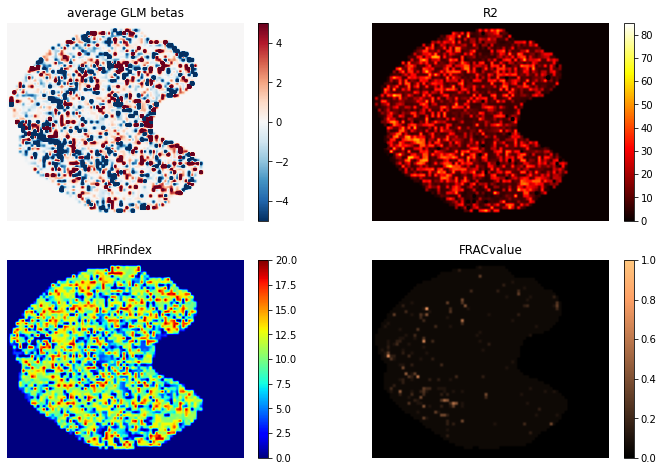

In [20]:
# we are going to plot several outputs from the FIT_HRF_GLMdenoise_RR GLM,
# which contains the full set of GLMsingle optimizations.

# we will plot betas, R2, optimal HRF indices, and the voxel frac values
plot_fields = ['betasmd','R2','HRFindex','FRACvalue']
colormaps = ['RdBu_r','hot','jet','copper']
clims = [[-5,5],[0,85],[0,20],[0,1]]

d_slice = 20
H, W, D = fmri_mask.shape

slice_mask = fmri_mask[:, :, d_slice]

plt.figure(figsize=(12,8))

for i in range(len(plot_fields)):
    
    plt.subplot(2,2,i+1)
    
    plot_data = np.zeros_like(fmri_mask, dtype=np.float32)
    
    if i == 0:
        # when plotting betas, for simplicity just average across all image presentations
        # this will yield a summary of whether voxels tend to increase or decrease their 
        # activity in response to the experimental stimuli (similar to outputs from 
        # an ONOFF GLM)
        
        plot_data[fmri_mask] = np.nanmean(results_glmsingle['typed'][plot_fields[i]], -1)
        titlestr = 'average GLM betas'
    
    else:
        # plot all other voxel-wise metrics as outputted from GLMsingle
        plot_data[fmri_mask] = np.squeeze(results_glmsingle['typed'][plot_fields[i]])
        titlestr = plot_fields[i]
    
    plt.imshow(plot_data[:, :, d_slice],cmap=colormaps[i], clim=clims[i])
    plt.colorbar()
    plt.title(titlestr)
    plt.axis(False)

In [ ]:
type_names = {
    'typea': 'onoff',
    'typeb': 'fithrf',
    'typec': 'fithrf_GLMdenoise',
    'typed': 'fithrf_GLMdenoise_RR'
}

num_voxels = fmri_mask.sum()
for type_name, results in results_glmsingle.items():
    result_name = type_names[type_name]
    print(result_name)
    result_path = output_path / result_name
    result_path.mkdir(exist_ok=True, parents=True)

    for k, v in results.items():
        if isinstance(v, np.ndarray):
            print(k, v.dtype, v.shape)
            if v.shape[0] == num_voxels:
                if len(v.shape) == 1:
                    out_img = np.zeros_like(fmri_mask, dtype=v.dtype if v.dtype != bool else int)
                    out_img[fmri_mask] = v
                    img = nib.Nifti1Image(out_img, np.eye(4))
                    nib.save(img, result_path / f'{result_name}_{k}.nii.gz')

        else:
            print(k, type(v))

In [12]:
design_concat = np.concatenate(design_batch)
design_concat.sum(axis=0)

array([3., 1., 1., 1., 6., 6., 3., 1., 1., 1., 1., 1., 1., 1., 3., 6., 3.,
       1., 1., 1., 3., 3., 6., 1., 6., 1., 1., 1., 1., 3., 1., 6., 1., 6.,
       1., 1., 1., 1., 3., 1., 1., 6., 1., 1., 1., 1., 1., 3., 3., 3., 1.,
       1., 1., 1., 1., 6., 1., 3., 6., 3., 1., 1., 1., 6., 3., 1., 1., 6.,
       1., 1., 1., 1., 3., 3., 1., 1., 6., 6., 1., 6., 1., 1., 1., 1., 3.,
       1., 1., 1., 3., 6., 1., 1., 1., 1., 1., 6., 3., 1., 3., 3., 1., 6.,
       1., 1., 1., 6., 1., 3., 1., 1., 1., 6., 6., 3., 1., 1., 1., 1., 3.,
       6., 1., 1., 1., 1., 1., 1., 3., 3., 3., 6., 1., 6., 1., 3., 1., 1.,
       1., 1., 1., 1., 1., 3., 1., 1., 3., 1., 3., 6., 1., 1., 1., 1., 1.,
       3., 6., 1., 3., 1., 1., 1., 6., 1., 1., 3., 1., 1., 3., 1., 1., 6.,
       3., 1., 1., 3., 6., 1., 1., 1., 6., 3., 1., 1., 1., 3., 6., 1., 1.,
       1., 1., 1., 1., 3., 6., 3., 1., 1., 1., 6., 1., 1., 3., 6., 3., 6.,
       1., 1., 1., 1., 6., 1., 1., 1., 6., 3., 1., 1., 3., 1., 1., 1., 3.,
       1., 3., 6., 1., 6.